In [ ]:
#test

In [16]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Classifiers and regressors
from sklearn.dummy import DummyClassifier, DummyRegressor

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV

# train test split and cross validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix

from sklearn.metrics import f1_score, accuracy_score, make_scorer
from sklearn.svm import SVC, LinearSVC


pd.set_option("display.max_colwidth", 200)

### Loading in data


In [54]:
# Helper functions to help with displaying data.
def class_count(y_data):
    counts = y_data.value_counts().to_list()

    data = {"Class": ["Non-Fraud", "Fraud"],
            "Count": counts}
    display(pd.DataFrame(data))

# Helper function to expidite tuning process:
# Returns a tune grid.
def tune(param_grid, pipeline, X_train, y_train, scoring_func):
    # Perform grid search with 5-fold cross validation
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring=scoring_func)
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters and corresponding score
    results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score']]
    results = pd.concat([results.drop('params', axis=1), 
                    results['params'].apply(lambda x: pd.Series(x))], axis=1)
    results.columns = ["Mean Test Score"] + list(param_grid.keys())
    return results


In [18]:
raw_df = pd.read_csv('data/card_transdata.csv')
raw_df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [19]:
# Shows that there are no null rows that we need to deal with. 
raw_df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

### Data imbalance check

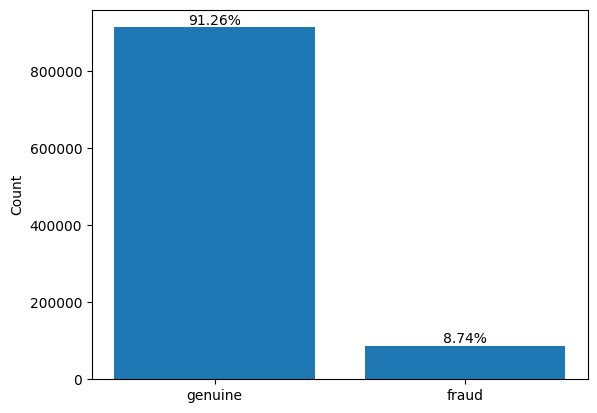

In [20]:
labels = ["genuine", "fraud"]
counts = raw_df["fraud"].value_counts().to_list()
proportion = counts / np.sum(counts) * 100

bar = plt.bar(labels, counts)
plt.ylabel("Count")

# add text inside each bar
for idx, rect in enumerate(bar):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{proportion[idx]:.2f}%', ha='center', va='bottom')

# display the chart
plt.show()

In [21]:
counts

[912597, 87403]

# Knn Classifier

As previously discussed in the preliminary data analysis, the credit card fraud dataset is highly imbalanced, with only 87,403 frauds observations of of 1000000 observations. Since kNN classification is a non-parametric algorithm, applying upsampling techniques like SMOTE would only increase the runtime of making predictions. Therefore, random downsampling will be employed to both increase efficiency and maintain a 50% ratio of each class.

In [22]:
# Stratified sampling on the class
X_train, X_test, y_train, y_test = train_test_split(
    raw_df.drop("fraud", axis = 1), 
    raw_df["fraud"], 
    test_size=0.80, 
    random_state=123, 
    stratify=raw_df["fraud"]
)
X_train.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
679281,14.228889,1.639855,4.104065,1.0,1.0,0.0,0.0
414524,19.058904,1.409901,3.408421,1.0,1.0,0.0,1.0
778192,2.646068,1.984384,2.859258,1.0,1.0,0.0,1.0
495061,12.625542,0.060618,1.035773,1.0,1.0,0.0,0.0
158233,14.586982,1.332998,2.657770,1.0,0.0,0.0,0.0


In [23]:
class_count(y_train)

,Class,Count
0,Non-Fraud,182519
1,Fraud,17481


Table X: A count of each class type in X_train

In [24]:
# Separate majority and minority classes
majority_class = X_train[y_train == 0]
minority_class = X_train[y_train == 1]

# Sample the majority class to balance the data
n_samples = len(minority_class)
majority_sampled = majority_class.sample(n=n_samples, replace=False, random_state=123)

# Concatenate the minority and sampled majority class dataframes
X_train_balanced = pd.concat([minority_class, majority_sampled], axis=0)
y_train_balanced = pd.Series([1] * n_samples + [0] * n_samples)
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced)

In [25]:
class_count(y_train_balanced)

,Class,Count
0,Non-Fraud,17481
1,Fraud,17481


Table X: The newly balanced training data

Knn is an algorithm that relies on the distances between the observations to classify new instances. If the scales of the different features in the dataset are not normalized, then the features with larger scales will dominate the distance metric which make it difficult for features with smaller scales to contribute meaningfully to the classification. In the case of credit card fraud, `distance_from_home` has a range of 10632.72 unit which is far large than the range our binary attributes. For this reason, the data will be scaled with `StandardScaler` before any other steps.

The process of selecting predictors and tuning hyperparameters are closely related. It may be the case that a certain number of predictors would work well for a certain k value but poorly for other k values, so in order to find the optimal number of predictors we have to test it with several k values. By utilizing a 5-fold cross-validation and testing 35 combinations of predictors and k values, we can concurrently try different pairs of k value and predictors. In regards to predictor selection, we will be using `SelectKBest` to perform univariate feature selection using the ANOVA statistical test. Each potential predictor will be analyzed with our class to determine if there were a statistically signficiant relationship between the two.

In [58]:
# Define the hyperparameters to tune
param_grid = {
    'selectkbest__k': [1, 2, 3, 4, 5, 6, 7],
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 15]
}

knn_pred_selection_clf = make_pipeline(
    StandardScaler(),
    SelectKBest(score_func=f_classif),
    KNeighborsClassifier()
)

knn_pred_selection_res = tune(
    param_grid=param_grid, 
    pipeline=knn_pred_selection_clf, 
    X_train=X_train_balanced, 
    y_train=y_train_balanced, 
    scoring_func='f1_macro'
)

In [56]:
knn_pred_selection_res.sort_values(by='Mean Test Score', ascending = False).head(10)

,Mean Test Score,selectkbest__k,kneighborsclassifier__n_neighbors
6,0.994394,3,7
13,0.994022,5,7
20,0.993364,7,7
27,0.992792,9,7
34,0.991476,15,7
5,0.990847,3,6
12,0.990103,5,6
19,0.989416,7,6
26,0.988644,9,6
33,0.987156,15,6


Table X: The 10 hyperparamter combinations that give the most efficient validation score

# Todo replace Table X with the table number of the above table
Table X notably shows that the top 5 accurate pair of hyperparameters use all 7 predictors from our original dataset. That means that each of the predictors are an important component to correctly classifying the label of any incoming transactions. We will now look closer into different k values over a larger range that what is shown in Table X by looking at odd values between [3, 69]

In [59]:
param_grid = {
    'kneighborsclassifier__n_neighbors': [2*i + 1 for i in range(1, 35)]
}

knn_hyperparameter_selection_clf = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier())

# Perform grid search with 5-fold cross validation
knn_hyperparameter_selection_res = tune(
    param_grid=param_grid, 
    pipeline=knn_hyperparameter_selection_clf, 
    X_train=X_train_balanced, 
    y_train=y_train_balanced, 
    scoring_func='f1_macro'
)

knn_hyperparameter_selection_res

,Mean Test Score,kneighborsclassifier__n_neighbors
0,0.994394,3
1,0.994022,5
2,0.993364,7
3,0.992792,9
4,0.992506,11
5,0.992048,13
6,0.991476,15
7,0.991076,17
8,0.990847,19
9,0.990561,21


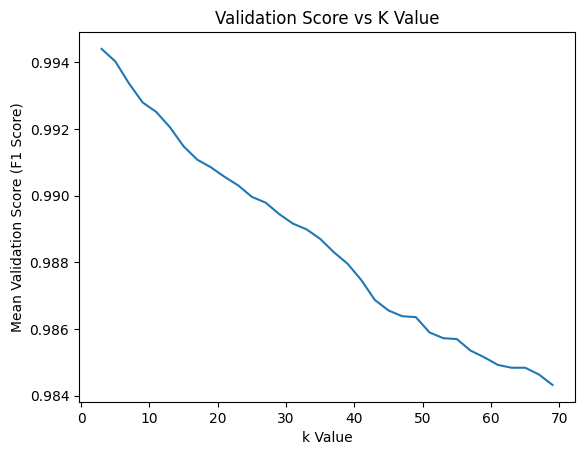

In [63]:
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the data as a line chart
ax.plot(
    knn_hyperparameter_selection_res["kneighborsclassifier__n_neighbors"],
    knn_hyperparameter_selection_res["Mean Test Score"]
)

# Set the title and axis labels
ax.set_title("Validation Score vs K Value")
ax.set_xlabel("k Value")
ax.set_ylabel("Mean Validation Score (F1 Score)")

# Show the chart
plt.show()

As shown from the above graph, most k values are very accurate in determining the transaction label only differing by a percent. We've decided to use a k value of 3 because it yielded the most accurate score in combination with out predictor selection as shown in table X (same value as the todo from above).

The final knn classifier can know be trained so we can test it on our testing data.

In [30]:
knn_clf = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors = 3))

knn_clf.fit(X_train_balanced, y_train_balanced)

In [ ]:
knn_pred = knn_clf.predict(X_test)
knn_f1score = f1_score(y_test, knn_pred)

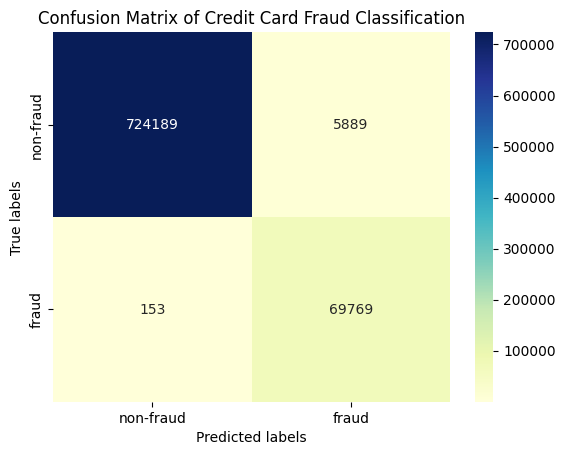

In [31]:
cm = confusion_matrix(y_test, knn_pred)

# Create a heatmap from the confusion matrix using seaborn
class_names = ['non-fraud', 'fraud']
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)

# Set the axis labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix of Credit Card Fraud Classification")

# Show the plot
plt.show()

# Todo include analysis of results, talk about accuracy, f1 score, if this is good enough, possible reasons from high fraud misclassifications.

# Support Vector Machines

Next we'll analyze the effectiveness of support vector machine classifiers in predicting credit card fraud. The two forms of kernels that we will explore are linear kernels and radial basis function kernels. If our dataset is linearly seperable, a linear kernel svm would be ideal because it's a parametric model which means it's only required to store a fixed number parameters, the coefficients of the hyperplane that separates the datas into non fraud and fraud. While it's possible to model more complex data using an RBF kernel, because it's a non parametric model, the cost grows with the size of our training data, which is not ideal in our case due to the number of transactions.

Similar to knn, we will have to deal with the unbalanced dataset. In the case of SVM it is possible tp use the `class_weight` argument to add bias to the minority class to balance the dataset but this also means that the algorithm with need to be fitted with 200k training examples. Due to the computational limitations of our computer, we will reuse the downsampled data that we used in knn classifier. Additionally, it is necessary to normalize the data because SVM is a distance based algorithm that tries to maximize the distance between the hyperplane and the support vectors.

We'll first begin creating our linear SVM classifier, by tuning our regularization hyperparameter `C`.

In [64]:
param_grid = {
    'linearsvc__C': [0.1, 1, 10, 100, 1000]
}

# Create an SVM classifier with a linear kernel
linear_svm_hyperparameter_selection_clf = make_pipeline(StandardScaler(), LinearSVC(max_iter=1000, random_state=123))

# Perform grid search with 5-fold cross validation
linear_svm_hyperparameter_selection_res = tune(
    param_grid=param_grid,
    pipeline=linear_svm_hyperparameter_selection_clf,
    X_train=X_train_balanced,
    y_train=y_train_balanced,
    scoring_func='f1_macro'
)

linear_svm_hyperparameter_selection_res

/home/jonomuffin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jonomuffin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jonomuffin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jonomuffin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jonomuffin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jonomuffin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: Convergenc

,Mean Test Score,linearsvc__C
0,0.933041,0.1
1,0.935300,1.0
2,0.939529,10.0
3,0.936766,100.0
4,0.919149,1000.0


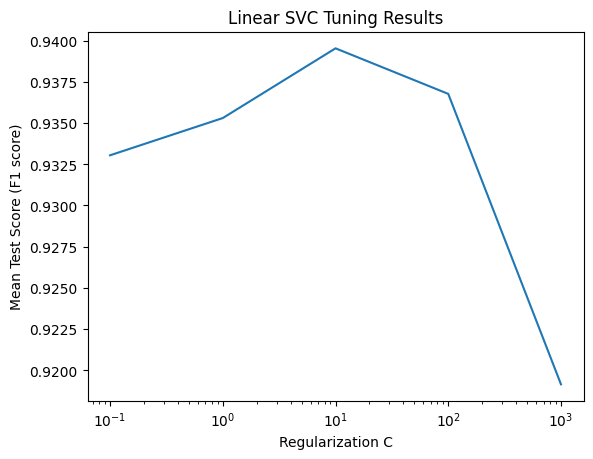

In [66]:
plt.plot(
    linear_svm_hyperparameter_selection_res["linearsvc__C"],
    linear_svm_hyperparameter_selection_res["Mean Test Score"]
)

# Sets log scale for regularization C
plt.xscale("log")

# Axis and Title labels
plt.xlabel("Regularization C")
plt.ylabel("Mean Test Score (F1 score)")
plt.title("Linear SVC Tuning Results")

plt.show()

The f1 score is optimized between `C = 10` and `C = 100`. Since a larger regularization constant biases. For our final linear support vector classifier, we will use `C = 10` as the larger the regularization parameter is the more likely it is to overfit the training data. 

In [34]:
# Fit the classifier to the training data
linear_svm_clf = make_pipeline(StandardScaler(), LinearSVC(max_iter=5000, random_state=123, C=10))
linear_svm_clf.fit(X_train_balanced, y_train_balanced)

y_pred = linear_svm_clf.predict(X_test)

linear_svm_f1score = accuracy_score(y_true=y_test, y_pred=y_pred)
linear_svm_f1score

/home/jonomuffin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.93551625

In [67]:
param_grid = {
    'svc__C': [0.1, 1, 100, 1000]
}

# Create an SVM classifier with a rbf kernel
rbf_svm_hyperparameter_selection_clf = make_pipeline(StandardScaler(), SVC(max_iter=1000, random_state=123, kernel='rbf'))

# Perform grid search with 5-fold cross validation
rbf_svm_hyperparameter_selection_res = tune(
    param_grid=param_grid,
    pipeline=rbf_svm_hyperparameter_selection_clf,
    X_train=X_train_balanced,
    y_train=y_train_balanced,
    scoring_func='f1_macro'
)

rbf_svm_hyperparameter_selection_res

/home/jonomuffin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jonomuffin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jonomuffin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jonomuffin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jonomuffin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: Conve

,Mean Test Score,svc__C
0,0.873382,0.1
1,0.967416,1.0
2,0.993221,100.0
3,0.982379,1000.0


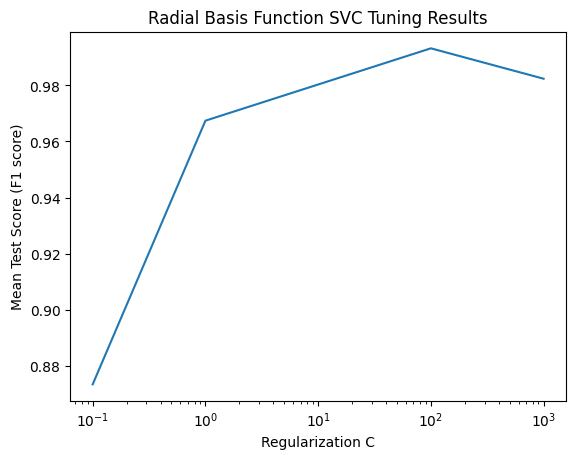

In [68]:
plt.plot(
    rbf_svm_hyperparameter_selection_res['svc__C'],
    rbf_svm_hyperparameter_selection_res["Mean Test Score"]
)

# Sets log scale for regularization C
plt.xscale("log")

# Axis and Title labels
plt.xlabel("Regularization C")
plt.ylabel("Mean Test Score (F1 score)")
plt.title("Radial Basis Function SVC Tuning Results")

plt.show()

The f1 score only seems to be decreasing after `C=100` so this would be the optimal regularization hyperparameter.

In [69]:
# Fit the classifier to the training data
rbf_svm_clf = make_pipeline(StandardScaler(), LinearSVC(max_iter=5000, random_state=123, C=100))
rbf_svm_clf.fit(X_train_balanced, y_train_balanced)

y_pred = rbf_svm_clf.predict(X_test)

rbf_svm_f1score = accuracy_score(y_true=y_test, y_pred=y_pred)
rbf_svm_f1score

/home/jonomuffin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9373475

# Conclusion

In [42]:
pd.DataFrame(
    {
        "Classifier": ["Knn", "Linear SVC", "RBF SVC", "Decision Tree", "Random Forest"],
        "Test F1-Score": [knn_f1score, linear_svm_f1score, rbf_svm_f1score, 0, 0],
        "Parametric or Non Parametric": ["Non Parametric", "Parametric", "Non Parametric", "Parametric", "Parametric"],
    }
)

,Classifier,Test F1-Score,Parametric or Non Parametric
0,Knn,0.958497,Non Parametric
1,Linear SVC,0.935516,Parametric
2,RBF SVC,0.937348,Non Parametric
3,Decision Tree,0.000000,Parametric
4,Random Forest,0.000000,Parametric


In [1]:
# Every time you start working you shoudl pull just in case someone else did something.